## Figure 1: Oldest sedimentary deposits of the Great Unconformity using digital database Macrostrat

In [2]:
# Convert lat/lng to numeric (fixes string issue)
import json
import requests
import geopandas as gpd
import pandas as pd
import pygmt
with open('columns_macro.json') as json_file:
    json_data = json.load(json_file)
data =dict(json_data['success']['data'])
f = gpd.GeoDataFrame.from_features(data)

url = f"https://macrostrat.org/api/units/?lith_class=sedimentary"
resp = requests.get(url).json()

columns =pd.json_normalize(resp['success']['data'])

sedimentary_strata_df=f.merge(columns, how='outer', on ='col_id')
#rand.to_file('macrostrat.gpml')
sedimentary_strata_df=sedimentary_strata_df[(sedimentary_strata_df.b_age>=472)&(sedimentary_strata_df.b_age<=635)]
sedimentary_strata_df[['geometry', 'col_id', 'col_name','b_age']].set_crs('EPSG:4326').to_file('./macrostrat_ProtoCamb.geojson')
sedimentary_strata_df.head()

,geometry,col_id,col_name,col_group,col_group_id,group_col_id,col_area_x,project_id_x,refs,unit_id,...,Fm,Gp,SGp,t_age,b_age,max_thick,min_thick,outcrop,pbdb_collections,pbdb_occurrences
17,"POLYGON ((-86.9992 34.6946, -86.9041 35.4015, ...",2,"Madison Co, Alabama",SAP,17.0,1.00,6345.4,1.0,[1],24.0,...,,Knox,,471.300,493.575,975.0,0.0,subsurface,0.0,0.0
18,"POLYGON ((-86.9992 34.6946, -86.9041 35.4015, ...",2,"Madison Co, Alabama",SAP,17.0,1.00,6345.4,1.0,[1],25.0,...,Ketona Dolomite,,,493.575,501.000,229.0,0.0,subsurface,0.0,0.0
19,"POLYGON ((-86.9992 34.6946, -86.9041 35.4015, ...",2,"Madison Co, Alabama",SAP,17.0,1.00,6345.4,1.0,[1],26.0,...,Conasauga,,,501.000,511.000,427.0,0.0,subsurface,0.0,0.0
20,"POLYGON ((-86.9992 34.6946, -86.9041 35.4015, ...",2,"Madison Co, Alabama",SAP,17.0,1.00,6345.4,1.0,[1],27.0,...,Rome,,,511.000,531.850,100.0,0.0,subsurface,0.0,0.0
35,"POLYGON ((-86.1746 34.7447, -86.1652 35.0947, ...",3,"Jackson County, Alabama",SAP,17.0,2.00,4134.0,1.0,[1],49.0,...,,Knox,,471.300,493.575,975.0,0.0,both,2.0,17.0


['#d8e8c4' '#AACEA1' '#8dad81' '#00a280' '#FED890']


text [WARNING]: Skipped 1 records as blank - please check input data.


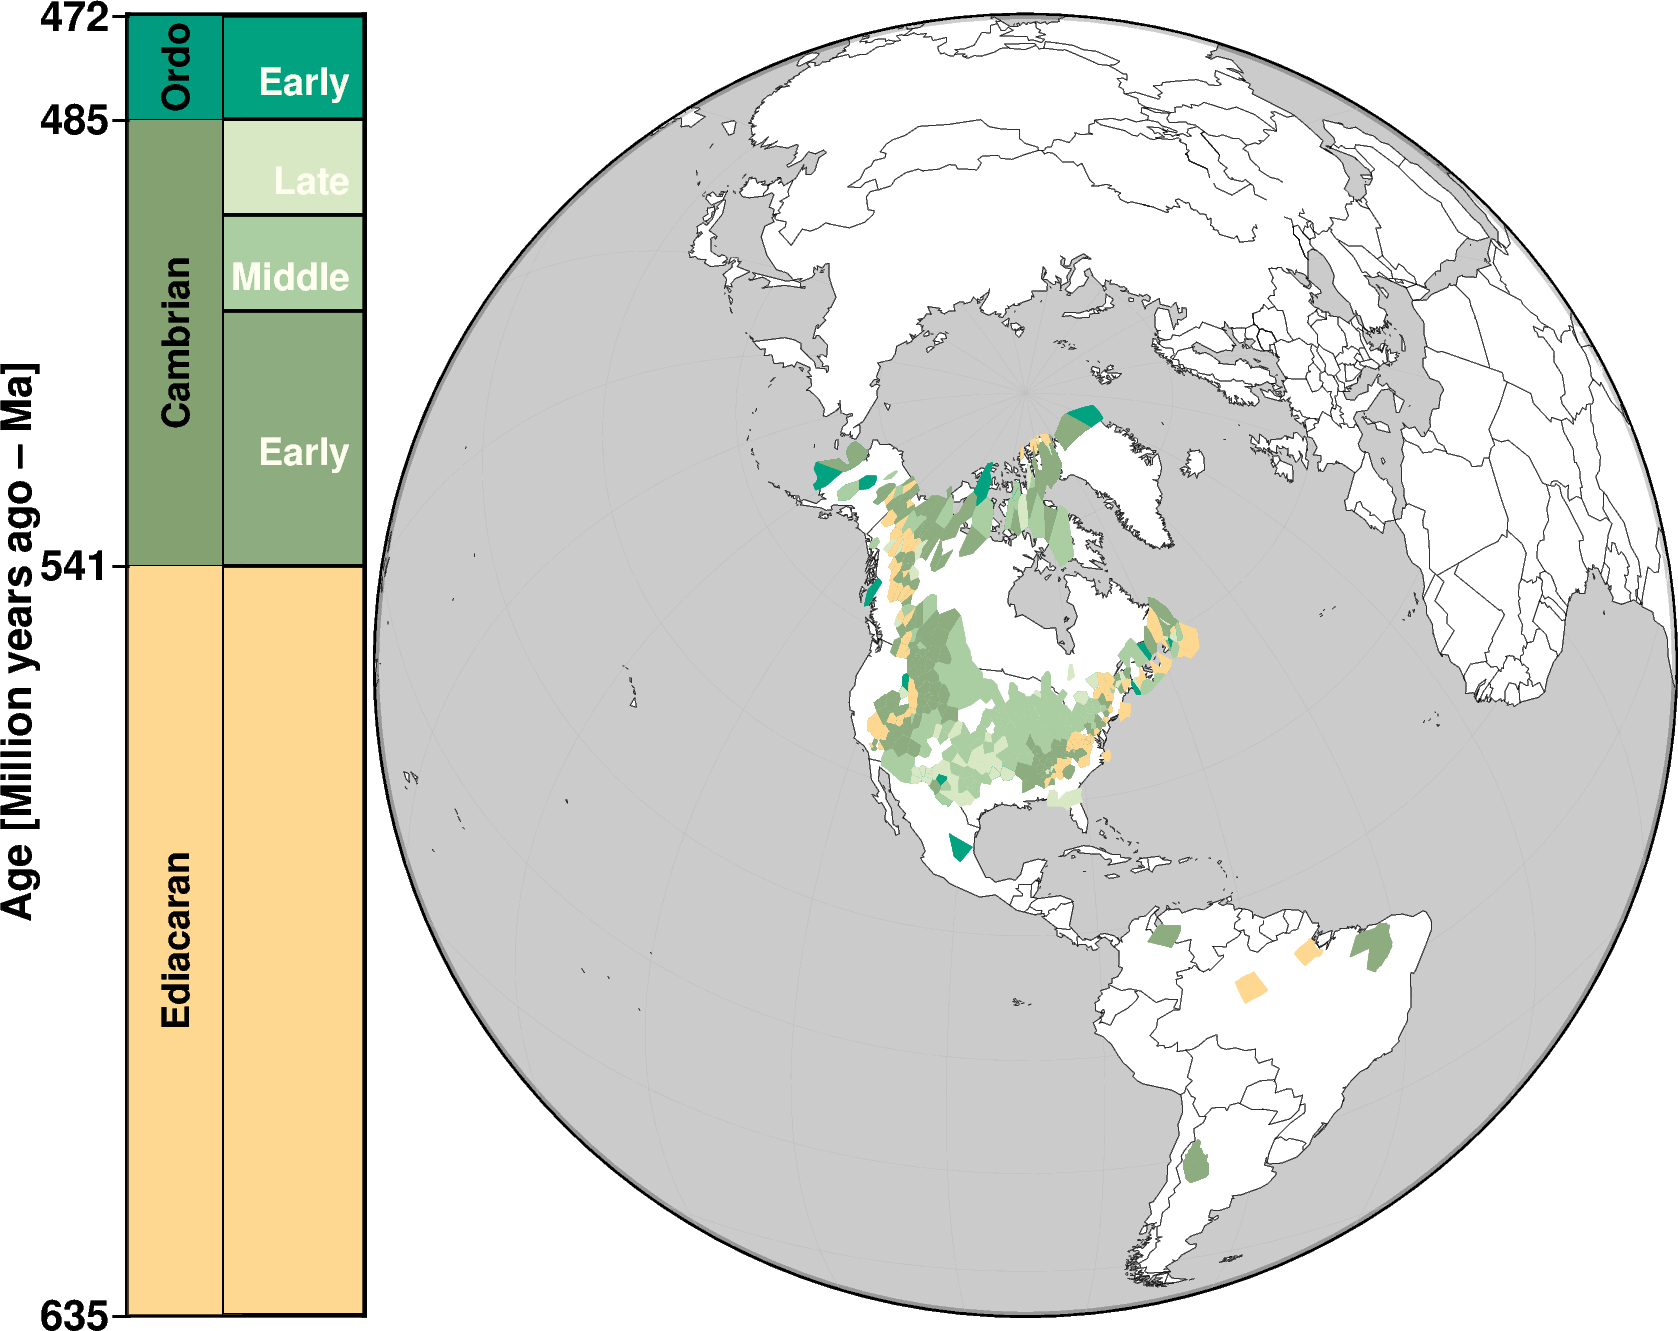

In [4]:
# Step 3: Classify by broad geologic age
import random
def classify_age(age):
    if age is None:
        return "Unknown"
    elif age > 2500:
        return "Archean"
    elif age > 1000:
        return "Proterozoic"
    elif age > 720:
        return "Neoproterozoic (Early)"
    elif age > 635:
        return "Neoproterozoic (Middle)"
    elif age > 541:
        return "Neoproterozoic (Late)"
    elif age > 509:
        return "Cambrian (Early)"
    elif age > 497:
        return "Cambrian (Middle)"
    elif age > 485:
        return "Cambrian (Late)"
    elif age > 443:
        return "Ordovician"
    elif age > 419:
        return "Silurian"
    elif age > 359:
        return "Devonian"
    elif age > 299:
        return "Carboniferous"
    elif age > 252:
        return "Permian"
    elif age > 201:
        return "Triassic"
    elif age > 145:
        return "Jurassic"
    elif age > 66:
        return "Cretaceous"
    else:
        return "Cenozoic"

sedimentary_strata_df["age_category"] = sedimentary_strata_df["b_age"].apply(classify_age)

# Step 4: Assign color to age category
color_map = {
    "Archean": "darkred",
    "Proterozoic": "orange3",
    "Neoproterozoic (Early)": "grey90",
    "Neoproterozoic (Middle)": "grey75",
    "Neoproterozoic (Late)": "#FED890",
    "Cambrian (Early)": "#8dad81",
    "Cambrian (Middle)": "#AACEA1",
    "Cambrian (Late)":  "#d8e8c4",
    "Ordovician": "#00a280",
    "Silurian": "lightorange",
    "Devonian": "lightred",
    "Carboniferous": "blue",
    "Permian": "purple",
    "Triassic": "magenta",
    "Jurassic": "violet",
    "Cretaceous": "pink",
    "Cenozoic": "gray",
    "Unknown": "lightgray"
}

sedimentary_strata_df["color"] = sedimentary_strata_df["age_category"].map(color_map)
print(sedimentary_strata_df['color'].unique())
fig1 = pygmt.Figure()
# Step 5: Create PyGMT figure
region='d'#[-140, 30, -25, 85]

#projection1="L-100/35/33/45/11c"
projection1 ="A-90/50/110/11c"

fig1.basemap(
    region=region,
    projection=projection1,
    frame= ""#["+tMacrostrat Columns",f"xa", "ya"]
    #["WenS","xaf", "yaf","tMacrostrat columns"],
)
fig1.coast(region =region, projection=projection1, land='white', water ='grey', borders=["1/0.1p,black"], shorelines ='1/0.1p', lakes='white', transparency=20)


# Plot each polygon individually with its fill color
#pygmt.makecpt(cmap="viridis", series=[400, 1000, 500])

for _, rows in sedimentary_strata_df.iterrows():
    color=rows['color']
    polygon=rows.geometry
    #print(rows.geometry, color)
    if polygon:
        if polygon.geom_type == "Polygon":
            coords = list(polygon.exterior.coords)
            fig1.plot(data=coords, pen=f"0.1p,{color}", fill =color, region=region, projection=projection1, transparency=0)
        elif polygon.geom_type == "MultiPolygon":
            for part in polygon.geoms:
                coords = list(part.exterior.coords)
                fig1.plot(data=coords, pen=f"0.1p,{color}", fill =color, region=region, projection=projection1, transparency=0)      

fig1.shift_origin(xshift= "-2.1c", yshift="0c")
# Minimal frame: only left y-axis with labels ("WS")
fig1.basemap(
    region=[-1, 1.5, 472, 635],
    projection="X2c/-11c",
    frame=["lrbt"] , #f"y+lAge [Million years ago-Ma]"]
)

# Stage intervals (period, stage, top, bottom, color)
stage_intervals = [
    # ("Neoproterozoic", "Early", 1000, 850, "gray80"),
    #("Neoproterozoic", "Middle", 850, 720, "gray70"),
    #("Neoproterozoic", "Late", 635, 541, "#f4b563"),
    ("Ediacaran", " ", 635, 541, "#FED890"),
    ("Cambrian", "Early", 541, 509, "#8dad81"),
    ("Cambrian", "Middle", 509, 497, "#AACEA1"),  #"#83a171"), #org
    ("Cambrian", "Late", 497, 485, "#d8e8c4"),
    ("Ordovician", "Early", 485, 472, "#00a280"),
]

# Period bounds (for outline + label + dividers)
period_bounds = {
    #"Neoproterozoic": (635, 541, "#e0556e"),
    "Ediacaran": (635, 541, "#FED890"),
    "Cambrian": (541, 485,"#83a171"),
    r"Ordo": (485, 472, "#019c7f"),
}

# Function to compute font size based on vertical height
def font_size(top, bottom):
    height = top - bottom
    # if height > 100:
    #     return "10p"
    # elif height > 30:
    #     return "9p"
    # else:
    #     return "8p"
    return "9p"
        

# Draw stage boxes and labels
for period, stage, top, bottom, color in stage_intervals:
    fig1.plot(
        x=[0, 0, 1.5, 1.5, 0],
        y=[top, bottom, bottom, top, top],
        pen="thin,black",
        fill=color,
    )
    fig1.text(
        text=stage,
        x=1.35,
        y=(top + bottom) / 2,
        font=f"{font_size(top, bottom)},Helvetica-Bold,ivory1",
        #fill='ivory1',
        justify= "TR", 
    )

# Draw period boxes, labels, and dividers
for period, (top, bottom, color) in period_bounds.items():
    # Outline box
    fig1.plot(
        x=[-1, -1, 0, 0, 0.2],
        y=[top, bottom, bottom, top, top],
        pen="0.1p,black",
        fill=color,
        no_clip=True,
        transparency =0
    )
    # Period label on left, vertical
    fig1.text(
        text=period,
        x=-0.5,
        y=(top + bottom) / 2,
        font=f"{font_size(top, bottom)},Helvetica-Bold,black",
        justify="CM",
        angle=90,
    )
for axis_label in [472, 485, 541, 635]:
    fig1.text(
        text=axis_label,
        x=-1,
        y=axis_label,
        font=f"10p,Helvetica-Bold,black",
        justify="CM",
        angle=0,
        no_clip=True,
        offset="-0.45/0"
    )
    
    fig1.text(
        text='–',
        x=-1,
        y=axis_label,
        font=f"7p,Helvetica-Bold,black",
        justify="CM",
        angle=0,
        no_clip=True,
        offset="-0.055/-0.035"
    )

fig1.text(
        text='Age [Million years ago – Ma]',
        x=-2,
        y=550,
        font=f"10p,Helvetica-Bold,black",
        justify="CM",
        angle=90,
        no_clip=True,
        offset="-0.15/-0.035"
    )

fig1.savefig('./MainFigures/Macrostrat_SedimentaryStrata_plot.png', dpi=300)
fig1.show()